In [1]:
!pip install --user --upgrade --editable gym-env

Obtaining file:///home/nibir/cs698r/project/gym-env
  Attempting uninstall: gym-env
    Found existing installation: gym-env 1.0.0
    Uninstalling gym-env-1.0.0:
      Successfully uninstalled gym-env-1.0.0
  Running setup.py develop for gym-env


In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
import time
import gym
import math
import pickle
SEEDS = [12, 42, 55, 78, 9999, 333]

%matplotlib inline

In [2]:
def argmax(q_values):
    top_value = float("-inf")
    ties = []
    for i in range(len(q_values)):
        val = q_values[i]
        if val > top_value:
            top_value = val
            ties = [i]
            continue
        elif val == top_value:
            ties.append(i)
    return np.random.choice(ties)

In [3]:
def greedy(net, state):
    with torch.no_grad():
        q_values = net(state).detach().numpy().squeeze()
    return np.argmax(q_values)

In [4]:
class decaying_epsilon_greedy():
    def __init__(self, init_epsilon=1.0, final_epsilon=0.3, max_steps=20000, decay_type='exp'):
        self.epsilon = init_epsilon
        self.final_epsilon = final_epsilon
        self.max_steps = max_steps
        self.eps_list=np.zeros(max_steps)
        lamda = 0.003
        for n in range(max_steps):
            if decay_type=='lin':
                self.eps_list[n] = ((final_epsilon - init_epsilon)*n + max_steps*init_epsilon)/max_steps
            else:
                self.eps_list[n] = (init_epsilon-final_epsilon)*np.exp(-n*lamda) + final_epsilon
        self.n = 0

    def update(self):
        if self.n >= self.max_steps: 
            self.epsilon = self.final_epsilon
        else:
            self.epsilon = self.eps_list[self.n]
        self.n += 1
        return self.epsilon

    def select_action(self, net, state):
        with torch.no_grad():
            q_values = net(state).detach().numpy().squeeze()
        if np.random.rand() <= self.epsilon:
            action = np.random.randint(len(q_values))
        else:
            action = argmax(q_values)
        self.update()
        return action

In [5]:
class ValueNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims, activation):
        super(ValueNetwork, self).__init__()
        self.activation = activation
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            self.hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
            x = x.unsqueeze(0)
        x = self.activation(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        x = self.output_layer(x)
        return x

In [6]:
class ReplayBuffer():
    def __init__(self, max_size, batch_size):
        self.max_size = max_size
        self.batch_size = batch_size
        self.id = 0
        self.size = 0
        self.states = np.empty(shape=(max_size), dtype=np.ndarray)
        self.actions = np.empty(shape=(max_size), dtype=np.ndarray)
        self.rewards = np.empty(shape=(max_size), dtype=np.ndarray)
        self.next_states = np.empty(shape=(max_size), dtype=np.ndarray)
        self.dones = np.empty(shape=(max_size), dtype=np.ndarray)

    def store(self, experience):
        state, action, reward, next_state, done = experience
        self.states[self.id] = state
        self.actions[self.id] = action
        self.rewards[self.id] = reward
        self.next_states[self.id] = next_state
        self.dones[self.id] = done
        self.id = (self.id + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self):
        ids = np.random.choice(self.size, self.batch_size, replace=False)
        experiences = torch.from_numpy(np.vstack(self.states[ids])).float(), torch.from_numpy(np.vstack(self.actions[ids])).long(), torch.from_numpy(np.vstack(self.rewards[ids])).float(), torch.from_numpy(np.vstack(self.next_states[ids])).float(), torch.from_numpy(np.vstack(self.dones[ids])).float()
        return experiences

In [1]:
class DDQN():
    def __init__(self, env, seed, gamma, MAX_TRAIN_EPISODES, optimizer, optimizer_LR, training_strategy, evaluation_strategy, update_frequency):
        self.env = env
        self.gamma = gamma
        self.env.seed(seed)
        torch.manual_seed(seed)
        self.MAX_TRAIN_EPISODES = MAX_TRAIN_EPISODES
        self.replay_buffer = ReplayBuffer(max_size=50000, batch_size=64)
        self.nn_online = ValueNetwork(6, env.action_space.n, hidden_dims=(512,128), activation=F.relu)
        self.nn_target = ValueNetwork(6, env.action_space.n, hidden_dims=(512,128), activation=F.relu)
        self.optimizer = optimizer(self.nn_online, optimizer_LR)
        self.training_strategy = training_strategy()
        self.evaluation_strategy = evaluation_strategy
        self.update_frequency = update_frequency

    def train_network(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        max_actions = self.nn_online(next_states).max(1)[1]
        Q_next = self.nn_target(next_states).detach()
        max_Q_next = Q_next[np.arange(len(dones)), max_actions].unsqueeze(1)
        td_target = rewards + (self.gamma * max_Q_next * (1 - dones))
        Q_curr = self.nn_online(states).gather(1, actions)
        td_error = td_target - Q_curr
        loss = td_error.pow(2).mul(0.5).mean()
        self.optimizer.zero_grad()
        loss.backward()        
        torch.nn.utils.clip_grad_norm_(self.nn_online.parameters(), 1e7)
        self.optimizer.step()
    
    def update_network(self):
        for target, online in zip(self.nn_target.parameters(), self.nn_online.parameters()):
            target.data.copy_(online.data)

    def train_agent(self):
        start_train = time.time()
        self.train_rewards = []
        self.eval_rewards = []    
        self.update_network()
        result = np.empty((self.MAX_TRAIN_EPISODES, 2))
        for episode in range(self.MAX_TRAIN_EPISODES):
            state, done = self.env.reset()
            self.train_rewards.append(0.0)

            while not done:
                action = self.training_strategy.select_action(self.nn_online, state)
                next_state, reward, done, _ = self.env.step(action)
                experience = (state, action, reward, next_state, float(done))
                self.replay_buffer.store(experience)
                self.train_rewards[-1] += reward
                if self.replay_buffer.size > self.replay_buffer.batch_size * 5:
                    experiences = self.replay_buffer.sample()
                    self.train_network(experiences)
                state = next_state
            if episode % self.update_frequency == 0:
                self.update_network()
            eval_reward = self.evaluate()
            self.eval_rewards.append(eval_reward)
            mov_mean_train_reward = np.mean(self.train_rewards[-100:])
            mov_mean_eval_reward = np.mean(self.eval_rewards[-100:])
            result[episode] = mov_mean_train_reward, mov_mean_eval_reward
            elapsed_time = time.strftime("%H:%M:%S", time.gmtime(time.time() - start_train))
            if episode<self.MAX_TRAIN_EPISODES-1:
                print(f"ELAPSED TIME: {elapsed_time} EPISODES: {episode} TRAIN REWARD: {mov_mean_train_reward} EVALUATION REWARD: {mov_mean_eval_reward}", end='\r')
            else:
                print(f"ELAPSED TIME: {elapsed_time} EPISODES: {episode} TRAIN REWARD: {mov_mean_train_reward} EVALUATION REWARD: {mov_mean_eval_reward}")
 
                
        print('TRAINING DONE')
        return result
    
    def evaluate(self):
        state, done = self.env.reset()
        returns = 0
        while not done:
            action = self.evaluation_strategy(self.nn_online, state)
            state, reward, done, _ = self.env.step(action)
            returns += reward
        return returns

In [51]:
ddqn_results = []
for seed in SEEDS:
    env = gym.make('gym_env:foraging-v1', interval_time=10, total_time=4)
    optimizer = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    training_strategy = lambda: decaying_epsilon_greedy(init_epsilon=1.0, final_epsilon=0.3, max_steps=20000, decay_type='exp')
    evaluation_strategy = lambda net, state: greedy(net, state)
    agent = DDQN(env, seed, 0.99, 1000, optimizer , 0.0007, training_strategy, evaluation_strategy, 10)
    result = agent.train_agent()
    ddqn_results.append(result)
ddqn_results = np.array(ddqn_results)

ELAPSED TIME: 00:04:26 EPISODES: 999 TRAIN REWARD: 433.1862226041542 EVALUATION REWARD: 518.373977765084187
TRAINING DONE
ELAPSED TIME: 00:04:27 EPISODES: 999 TRAIN REWARD: 282.00344476207187 EVALUATION REWARD: 155.00621202040896
TRAINING DONE
ELAPSED TIME: 00:04:55 EPISODES: 999 TRAIN REWARD: 434.3232109751628 EVALUATION REWARD: 632.360072514021684
TRAINING DONE
ELAPSED TIME: 00:04:26 EPISODES: 999 TRAIN REWARD: 298.2056181491382 EVALUATION REWARD: 218.804063223443826
TRAINING DONE
ELAPSED TIME: 00:06:31 EPISODES: 999 TRAIN REWARD: 263.73987726838 EVALUATION REWARD: 89.708484378973684345
TRAINING DONE
ELAPSED TIME: 00:05:27 EPISODES: 999 TRAIN REWARD: 241.24295058801042 EVALUATION REWARD: 36.468672858135314
TRAINING DONE


In [2]:
class DQN():
    def __init__(self, env, seed, gamma, MAX_TRAIN_EPISODES, optimizer, optimizer_LR, training_strategy, evaluation_strategy, update_frequency):
        self.env = env
        self.gamma = gamma
        self.env.seed(seed)
        torch.manual_seed(seed)
        self.MAX_TRAIN_EPISODES = MAX_TRAIN_EPISODES
        self.replay_buffer = ReplayBuffer(max_size=50000, batch_size=64)
        self.nn_online = ValueNetwork(6, env.action_space.n, hidden_dims=(512,128), activation=F.relu)
        self.nn_target = ValueNetwork(6, env.action_space.n, hidden_dims=(512,128), activation=F.relu)
        self.optimizer = optimizer(self.nn_online, optimizer_LR)
        self.training_strategy = training_strategy()
        self.evaluation_strategy = evaluation_strategy
        self.update_frequency = update_frequency

    def train_network(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        max_actions = self.nn_target(next_states).max(1)[1]
        Q_next = self.nn_target(next_states).detach()
        max_Q_next = Q_next[np.arange(len(dones)), max_actions].unsqueeze(1)
        td_target = rewards + (self.gamma * max_Q_next * (1 - dones))
        Q_curr = self.nn_online(states).gather(1, actions)
        td_error = td_target - Q_curr
        loss = td_error.pow(2).mul(0.5).mean()
        self.optimizer.zero_grad()
        loss.backward()        
        torch.nn.utils.clip_grad_norm_(self.nn_online.parameters(), 1e7)
        self.optimizer.step()
    
    def update_network(self):
        for target, online in zip(self.nn_target.parameters(), self.nn_online.parameters()):
            target.data.copy_(online.data)

    def train_agent(self):
        start_train = time.time()
        self.train_rewards = []
        self.eval_rewards = []    
        self.update_network()
        result = np.empty((self.MAX_TRAIN_EPISODES, 2))
        for episode in range(self.MAX_TRAIN_EPISODES):
            state, done = self.env.reset()
            self.train_rewards.append(0.0)

            while not done:
                action = self.training_strategy.select_action(self.nn_online, state)
                next_state, reward, done, _ = self.env.step(action)
                experience = (state, action, reward, next_state, float(done))
                self.replay_buffer.store(experience)
                self.train_rewards[-1] += reward
                if self.replay_buffer.size > self.replay_buffer.batch_size:
                    experiences = self.replay_buffer.sample()
                    self.train_network(experiences)
                state = next_state
            if episode % self.update_frequency == 0:
                self.update_network()
            eval_reward = self.evaluate()
            self.eval_rewards.append(eval_reward)
            mov_mean_train_reward = np.mean(self.train_rewards[-100:])
            mov_mean_eval_reward = np.mean(self.eval_rewards[-100:])
            result[episode] = mov_mean_train_reward, mov_mean_eval_reward
            elapsed_time = time.strftime("%H:%M:%S", time.gmtime(time.time() - start_train))
            if episode<self.MAX_TRAIN_EPISODES-1:
                print(f"ELAPSED TIME: {elapsed_time} EPISODES: {episode} TRAIN REWARD: {mov_mean_train_reward} EVALUATION REWARD: {mov_mean_eval_reward}", end='\r', flush=True)
            else:
                print(f"ELAPSED TIME: {elapsed_time} EPISODES: {episode} TRAIN REWARD: {mov_mean_train_reward} EVALUATION REWARD: {mov_mean_eval_reward}")
 
                
        print('TRAINING DONE')
        return result
    
    def evaluate(self):
        state, done = self.env.reset()
        returns = 0
        while not done:
            action = self.evaluation_strategy(self.nn_online, state)
            state, reward, done, _ = self.env.step(action)
            returns += reward
        return returns

In [17]:
dqn_results = []
for seed in SEEDS:
    env = gym.make('gym_env:foraging-v1', interval_time=10, total_time=4)
    optimizer = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    training_strategy = lambda: decaying_epsilon_greedy(init_epsilon=1.0, final_epsilon=0.3, max_steps=20000, decay_type='exp')
    evaluation_strategy = lambda net, state: greedy(net, state)
    agent = DQN(env, seed, 0.99, 1000, optimizer , 0.0007, training_strategy, evaluation_strategy, 15)
    result = agent.train_agent()
    dqn_results.append(result)
dqn_results = np.array(dqn_results)

ELAPSED TIME: 00:05:58 EPISODES: 999 TRAIN REWARD: 101.83365798670867 EVALUATION REWARD: 4.3821519077355124
TRAINING DONE
ELAPSED TIME: 00:05:40 EPISODES: 999 TRAIN REWARD: 162.6143832031833 EVALUATION REWARD: 79.6519182236094184
TRAINING DONE
ELAPSED TIME: 00:06:27 EPISODES: 999 TRAIN REWARD: 237.4808525176522 EVALUATION REWARD: 30.7509697826350152
TRAINING DONE
ELAPSED TIME: 00:06:13 EPISODES: 999 TRAIN REWARD: 464.4020467997193 EVALUATION REWARD: 525.144752690108586
TRAINING DONE
ELAPSED TIME: 00:08:18 EPISODES: 999 TRAIN REWARD: 115.85243000900815 EVALUATION REWARD: 9.3478108627103224
TRAINING DONE
ELAPSED TIME: 00:08:47 EPISODES: 999 TRAIN REWARD: 367.3493917720815 EVALUATION REWARD: 361.483792513674524
TRAINING DONE


In [19]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims, activation=F.relu):
        super(PolicyNetwork,self).__init__()
        self.activation = activation
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            self.hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)
        
    def forward(self, state):
        x = state
        if not torch.is_tensor(x):
            x = torch.tensor(x, dtype=torch.float)
            x.unsqueeze(0)
        x = self.activation(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        x = self.output_layer(x)
        return x
    
    def select_action(self, state):
        probs = self.forward(state)
        m = torch.distributions.Categorical(logits=probs)
        action = m.sample()
        log_prob = m.log_prob(action).unsqueeze(-1)
        entropy = m.entropy().unsqueeze(-1)
        return action, log_prob, entropy
        
    def select_greedy_action(self, state):
        probs = self.forward(state)
        return argmax(probs)

In [33]:
class VPG():
    def __init__(self, env, seed, gamma, MAX_TRAIN_EPISODES, policy_optimizer, policy_LR, policy_max_grad_norm, value_optimizer, value_LR, value_max_grad_norm, beta):
        self.env = env
        self.env.seed(seed)
        torch.manual_seed(seed)
        self.gamma = gamma
        self.MAX_TRAIN_EPISODES = MAX_TRAIN_EPISODES
        self.nn_policy = PolicyNetwork(6, self.env.action_space.n, hidden_dims=(128,64), activation=F.relu)
        self.policy_optimizer = policy_optimizer(self.nn_policy, policy_LR)
        self.policy_max_grad_norm = policy_max_grad_norm
        self.nn_value = ValueNetwork(6, 1, hidden_dims=(256,128), activation=F.relu)
        self.value_optimizer = value_optimizer(self.nn_value, value_LR)
        self.value_max_grad_norm = value_max_grad_norm
        self.beta = beta
        
    def get_stepwise_returns_discounts(self):
        T = len(self.rewards)
        discounts = np.logspace(0, T, num=T, base=self.gamma, endpoint=False)
        returns = np.array([np.sum(discounts[:T-t] * self.rewards[t:]) for t in range(T)])
        return torch.FloatTensor(returns).unsqueeze(1), torch.FloatTensor(discounts).unsqueeze(1)

    def train_value_policy_networks(self):
        returns, discounts = self.get_stepwise_returns_discounts()
        self.log_probs = torch.cat(self.log_probs)
        self.entropies = torch.cat(self.entropies) 
        self.values = torch.cat(self.values)
        deltas = returns - self.values
        baseline_loss = -(discounts * deltas.detach() * self.log_probs).mean()
        entropy_loss = -self.entropies.mean()
        policy_loss = baseline_loss + self.beta * entropy_loss
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.nn_policy.parameters(), self.policy_max_grad_norm)
        self.policy_optimizer.step()
        value_loss = deltas.pow(2).mul(0.5).mean()
        self.value_optimizer.zero_grad()
        value_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.nn_value.parameters(), self.value_max_grad_norm)
        self.value_optimizer.step()

    def train_agent(self):
        start_train = time.time()
        self.train_rewards = []
        self.eval_rewards = []
        self.average_rewrad = 0
        result = np.empty((self.MAX_TRAIN_EPISODES, 2))
        for episode in range(self.MAX_TRAIN_EPISODES):
            state, done = self.env.reset()
            self.train_rewards.append(0.0)
            self.log_probs, self.entropies, self.rewards, self.values = [], [], [], []
            
            while not done:
                action, log_prob, entropy = self.nn_policy.select_action(state)
                next_state, reward, done, _ = self.env.step(action)

                self.log_probs.append(log_prob)
                self.entropies.append(entropy)
                self.rewards.append(reward)
                self.values.append(self.nn_value(state))

                self.train_rewards[-1] += reward
                state=next_state
                
            self.train_value_policy_networks()
            eval_reward = self.eval_agent()
            self.eval_rewards.append(eval_reward)
            mov_mean_train_reward = np.mean(self.train_rewards[-100:])
            mov_mean_eval_reward = np.mean(self.eval_rewards[-100:])
            result[episode] = mov_mean_train_reward, mov_mean_eval_reward
            elapsed_time = time.strftime("%H:%M:%S", time.gmtime(time.time() - start_train))
            if episode<self.MAX_TRAIN_EPISODES-1:
                print(f"ELAPSED TIME: {elapsed_time} EPISODES: {episode} TRAIN REWARD: {mov_mean_train_reward} EVALUATION REWARD: {mov_mean_eval_reward}", end='\r', flush=True)
            else:
                print(f"ELAPSED TIME: {elapsed_time} EPISODES: {episode} TRAIN REWARD: {mov_mean_train_reward} EVALUATION REWARD: {mov_mean_eval_reward}")
 
                
        print('TRAINING DONE')
        return result
    
    def eval_agent(self):
        state, done = self.env.reset()
        returns = 0
        while not done:
            action = self.nn_policy.select_greedy_action(state)
            state, reward, done, _ = self.env.step(action)
            returns += reward
        return returns

In [21]:
vpg_results = []
for seed in SEEDS:
    env = gym.make('gym_env:foraging-v1', interval_time=10, total_time=4)
    policy_optimizer = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    policy_LR = 0.0005
    policy_max_grad_norm = 1
    value_optimizer = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    value_LR = 0.0007
    value_max_grad_norm = float('inf')
    beta = 0.001
    agent = VPG(env, seed, 1.00, 1000, policy_optimizer, policy_LR, policy_max_grad_norm, value_optimizer, value_LR, value_max_grad_norm, beta)
    result = agent.train_agent()
    vpg_results.append(result)
vpg_results = np.array(vpg_results)

ELAPSED TIME: 00:05:53 EPISODES: 999 TRAIN REWARD: 807.2798301668763 EVALUATION REWARD: 147.605239476675024
TRAINING DONE
ELAPSED TIME: 00:05:03 EPISODES: 999 TRAIN REWARD: 770.075736236016 EVALUATION REWARD: 83.04137117732247828
TRAINING DONE
ELAPSED TIME: 00:04:10 EPISODES: 999 TRAIN REWARD: 707.7707342253858 EVALUATION REWARD: 79.1186720743461661
TRAINING DONE
ELAPSED TIME: 00:02:51 EPISODES: 999 TRAIN REWARD: 823.7009115793289 EVALUATION REWARD: 433.679491422754734
TRAINING DONE
ELAPSED TIME: 00:02:05 EPISODES: 999 TRAIN REWARD: 805.7773026501882 EVALUATION REWARD: 855.384818649874264
TRAINING DONE
ELAPSED TIME: 00:03:30 EPISODES: 999 TRAIN REWARD: 822.885146229547 EVALUATION REWARD: 820.275655289570256
TRAINING DONE


In [75]:
ddqn_train_mean_10, ddqn_eval_mean_10 = np.mean(ddqn_results, axis=0).T
dqn_train_mean_10, dqn_eval_mean_10 = np.mean(dqn_results, axis=0).T
vpg_train_mean_10, vpg_eval_mean_10 = np.mean(vpg_results, axis=0).T

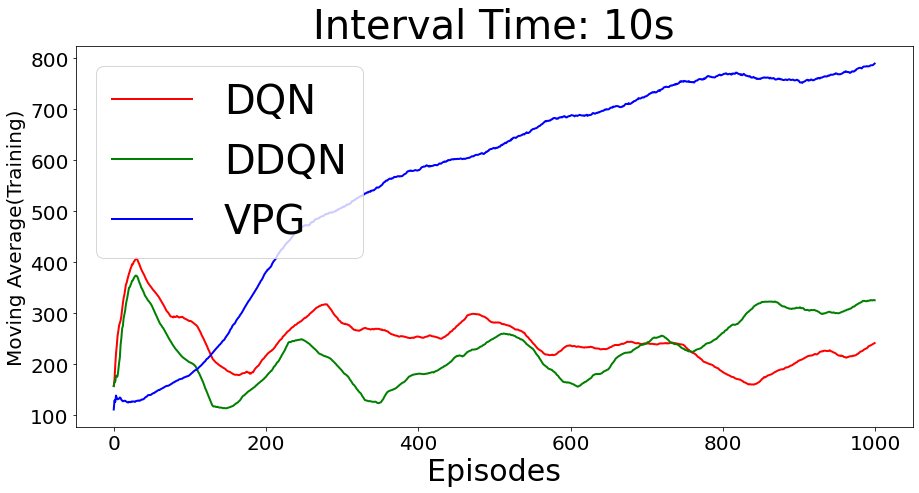

In [83]:
#Plots for moving rewards training
fig, axs = plt.subplots(1, 1, figsize=(15,7))
plt.plot(dqn_train_mean_10, 'r', label='DQN', linewidth=2)
plt.plot(ddqn_train_mean_10, 'g', label='DDQN', linewidth=2)
plt.plot(vpg_train_mean_10, 'b', label='VPG', linewidth=2)

plt.legend(fontsize=40, loc='upper left')
plt.ylabel('Moving Average(Training)', fontsize=20)
plt.xlabel('Episodes', fontsize=30)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Interval Time: 10s', fontsize=40)
plt.savefig('deep_1.pdf')

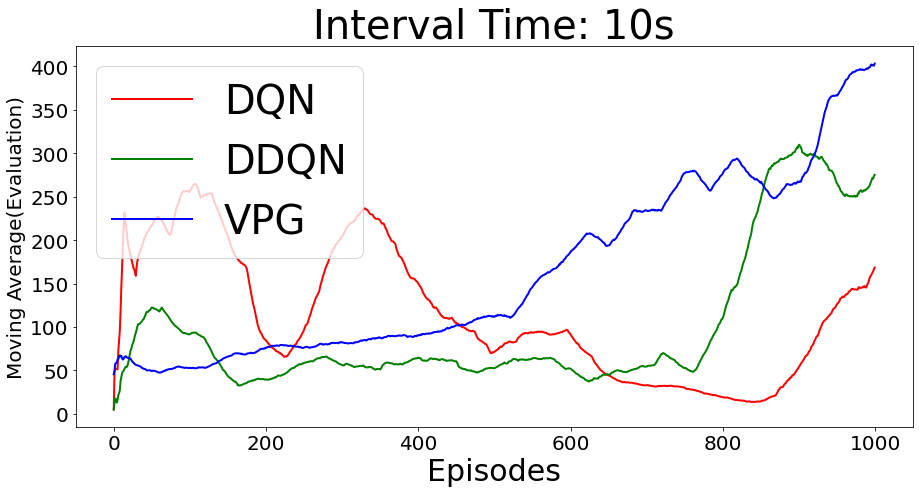

In [84]:
#Plots for moving rewards training
fig, axs = plt.subplots(1, 1, figsize=(15,7))
plt.plot(dqn_eval_mean_10, 'r', label='DQN', linewidth=2)
plt.plot(ddqn_eval_mean_10, 'g', label='DDQN', linewidth=2)
plt.plot(vpg_eval_mean_10, 'b', label='VPG', linewidth=2)

plt.legend(fontsize=40, loc='upper left')
plt.ylabel('Moving Average(Evaluation)', fontsize=20)
plt.xlabel('Episodes', fontsize=30)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Interval Time: 10s', fontsize=40)
plt.savefig('deep_2.pdf')

In [22]:
ddqn_results_1 = []
for seed in SEEDS:
    env = gym.make('gym_env:foraging-v1', interval_time=3, total_time=4)
    optimizer = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    training_strategy = lambda: decaying_epsilon_greedy(init_epsilon=1.0, final_epsilon=0.3, max_steps=20000, decay_type='exp')
    evaluation_strategy = lambda net, state: greedy(net, state)
    agent = DDQN(env, seed, 0.99, 1000, optimizer , 0.0007, training_strategy, evaluation_strategy, 10)
    result = agent.train_agent()
    ddqn_results_1.append(result)
ddqn_results_1 = np.array(ddqn_results_1)

ELAPSED TIME: 00:12:44 EPISODES: 999 TRAIN REWARD: 761.6180653394883 EVALUATION REWARD: 761.0354364414513477
TRAINING DONE
ELAPSED TIME: 00:14:10 EPISODES: 999 TRAIN REWARD: 925.8270871109395 EVALUATION REWARD: 1025.50688065161885
TRAINING DONE
ELAPSED TIME: 00:13:45 EPISODES: 999 TRAIN REWARD: 699.2453092059088 EVALUATION REWARD: 584.459313815124664
TRAINING DONE
ELAPSED TIME: 00:13:23 EPISODES: 999 TRAIN REWARD: 690.8411268276313 EVALUATION REWARD: 501.1424767692322468
TRAINING DONE
ELAPSED TIME: 00:14:54 EPISODES: 999 TRAIN REWARD: 708.9097164243509 EVALUATION REWARD: 786.373565125023864
TRAINING DONE
ELAPSED TIME: 00:19:49 EPISODES: 999 TRAIN REWARD: 602.3419538385665 EVALUATION REWARD: 469.742867182848235
TRAINING DONE


In [55]:
dqn_results_1 = []
for seed in SEEDS:
    env = gym.make('gym_env:foraging-v1', interval_time=3, total_time=4)
    optimizer = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    training_strategy = lambda: decaying_epsilon_greedy(init_epsilon=1.0, final_epsilon=0.3, max_steps=20000, decay_type='exp')
    evaluation_strategy = lambda net, state: greedy(net, state)
    agent = DQN(env, seed, 0.99, 1000, optimizer , 0.0007, training_strategy, evaluation_strategy, 15)
    result = agent.train_agent()
    dqn_results_1.append(result)
dqn_results_1 = np.array(dqn_results_1)

ELAPSED TIME: 00:18:46 EPISODES: 999 TRAIN REWARD: 612.4381131053408 EVALUATION REWARD: 568.340828347836556
TRAINING DONE
ELAPSED TIME: 00:21:12 EPISODES: 999 TRAIN REWARD: 770.3728315661435 EVALUATION REWARD: 790.801511395419552
TRAINING DONE
ELAPSED TIME: 00:22:27 EPISODES: 999 TRAIN REWARD: 311.5821238555791 EVALUATION REWARD: 248.5320344128657642
TRAINING DONE
ELAPSED TIME: 00:13:40 EPISODES: 999 TRAIN REWARD: 578.9091861005154 EVALUATION REWARD: 244.6905712218360242
TRAINING DONE
ELAPSED TIME: 00:13:53 EPISODES: 999 TRAIN REWARD: 862.1959850881702 EVALUATION REWARD: 922.430574824100534
TRAINING DONE
ELAPSED TIME: 00:09:46 EPISODES: 999 TRAIN REWARD: 564.1349799573414 EVALUATION REWARD: 396.4550859016451624
TRAINING DONE


In [58]:
vpg_results_1 = []
for seed in SEEDS:
    env = gym.make('gym_env:foraging-v1', interval_time=3, total_time=4)
    policy_optimizer = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    policy_LR = 0.0005
    policy_max_grad_norm = 1
    value_optimizer = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    value_LR = 0.0007
    value_max_grad_norm = float('inf')
    beta = 0.001
    agent = VPG(env, seed, 1.00, 1000, policy_optimizer, policy_LR, policy_max_grad_norm, value_optimizer, value_LR, value_max_grad_norm, beta)
    result = agent.train_agent()
    vpg_results_1.append(result)
vpg_results_1 = np.array(vpg_results_1)

ELAPSED TIME: 05:53:09 EPISODES: 999 TRAIN REWARD: 977.7967470994848 EVALUATION REWARD: 942.838150942930454
TRAINING DONE
ELAPSED TIME: 00:03:01 EPISODES: 999 TRAIN REWARD: 1163.2689687957977 EVALUATION REWARD: 660.02104129821773
TRAINING DONE
ELAPSED TIME: 00:03:57 EPISODES: 999 TRAIN REWARD: 1106.6135462178793 EVALUATION REWARD: 1060.8174705365193
TRAINING DONE
ELAPSED TIME: 00:04:01 EPISODES: 999 TRAIN REWARD: 1227.720969750705 EVALUATION REWARD: 988.734144748429235
TRAINING DONE
ELAPSED TIME: 00:03:36 EPISODES: 999 TRAIN REWARD: 1221.7698359202623 EVALUATION REWARD: 1102.9807735830866
TRAINING DONE
ELAPSED TIME: 00:04:04 EPISODES: 999 TRAIN REWARD: 1221.758550700732 EVALUATION REWARD: 957.951806127374867
TRAINING DONE


In [65]:
ddqn_train_mean, ddqn_eval_mean = np.mean(ddqn_results_1, axis=0).T
dqn_train_mean, dqn_eval_mean = np.mean(dqn_results_1, axis=0).T
vpg_train_mean, vpg_eval_mean = np.mean(vpg_results_1, axis=0).T

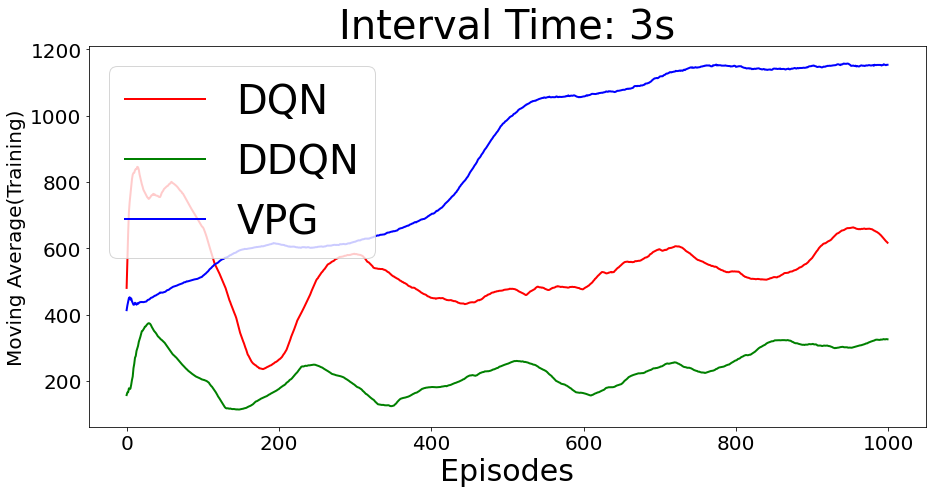

In [85]:
#Plots for moving rewards training
fig, axs = plt.subplots(1, 1, figsize=(15,7))
plt.plot(dqn_train_mean, 'r', label='DQN', linewidth=2)
plt.plot(ddqn_train_mean, 'g', label='DDQN', linewidth=2)
plt.plot(vpg_train_mean, 'b', label='VPG', linewidth=2)

plt.legend(fontsize=40, loc='upper left')
plt.ylabel('Moving Average(Training)', fontsize=20)
plt.xlabel('Episodes', fontsize=30)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Interval Time: 3s', fontsize=40)
plt.savefig('deep_5.pdf')

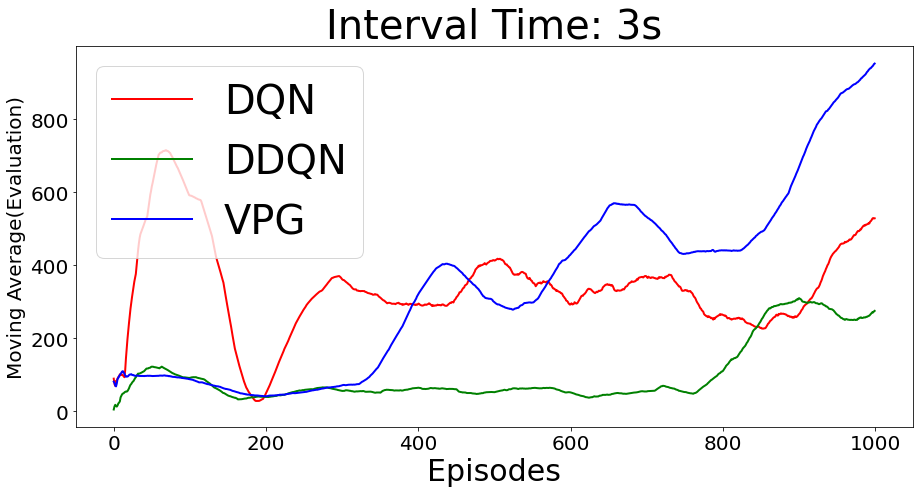

In [140]:
#Plots for moving rewards evaluation
fig, axs = plt.subplots(1, 1, figsize=(15,7))
plt.plot(dqn_eval_mean, 'r', label='DQN', linewidth=2)
plt.plot(ddqn_eval_mean, 'g', label='DDQN', linewidth=2)
plt.plot(vpg_eval_mean, 'b', label='VPG', linewidth=2)

plt.legend(fontsize=40, loc='upper left')
plt.ylabel('Moving Average(Evaluation)', fontsize=20)
plt.xlabel('Episodes', fontsize=30)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Interval Time: 3s', fontsize=40)
plt.savefig('deep_6.pdf')

In [103]:
file_name = "dqn.pkl"

open_file = open(file_name, "wb")
pickle.dump(dqn_results, open_file)
open_file.close()

In [92]:
open_file = open(file_name, "rb")
dqn_loaded = pickle.load(open_file)
open_file.close()

In [104]:
file_name = "ddqn.pkl"

open_file = open(file_name, "wb")
pickle.dump(ddqn_results, open_file)
open_file.close()

In [105]:
file_name = "vpg.pkl"

open_file = open(file_name, "wb")
pickle.dump(vpg_results, open_file)
open_file.close()

In [106]:
file_name = "dqn_1.pkl"

open_file = open(file_name, "wb")
pickle.dump(dqn_results_1, open_file)
open_file.close()

In [107]:
file_name = "ddqn_1.pkl"

open_file = open(file_name, "wb")
pickle.dump(ddqn_results_1, open_file)
open_file.close()

In [108]:
file_name = "vpg_1.pkl"

open_file = open(file_name, "wb")
pickle.dump(vpg_results_1, open_file)
open_file.close()

In [126]:
train_ddqn_max, eval_ddqn_max = np.max(ddqn_results, axis=0).T
train_ddqn_min, eval_ddqn_min = np.min(ddqn_results, axis=0).T
train_ddqn_mean, eval_ddqn_mean = np.mean(ddqn_results, axis=0).T
train_dqn_max, eval_dqn_max = np.max(dqn_results, axis=0).T
train_dqn_min, eval_dqn_min = np.min(dqn_results, axis=0).T
train_dqn_mean, eval_dqn_mean = np.mean(dqn_results, axis=0).T
train_vpg_max, eval_vpg_max = np.max(vpg_results, axis=0).T
train_vpg_min, eval_vpg_min = np.min(vpg_results, axis=0).T
train_vpg_mean, eval_vpg_mean = np.mean(vpg_results, axis=0).T
x = np.arange(np.max((len(train_ddqn_mean), len(train_dqn_mean))))

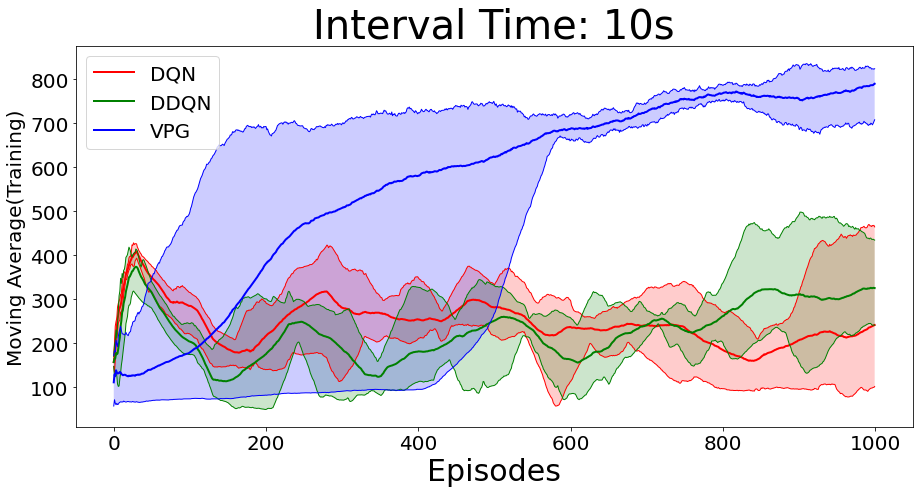

In [142]:
fig, axs = plt.subplots(1, 1, figsize=(15,7))

plt.plot(train_dqn_max, 'r', linewidth=1)
plt.plot(train_dqn_min, 'r', linewidth=1)
plt.plot(train_dqn_mean, 'r', label='DQN', linewidth=2)
plt.fill_between(x, train_dqn_min, train_dqn_max, facecolor='r', alpha=0.2)

plt.plot(train_ddqn_max, 'g', linewidth=1)
plt.plot(train_ddqn_min, 'g', linewidth=1)
plt.plot(train_ddqn_mean, 'g', label='DDQN', linewidth=2)
plt.fill_between(x, train_ddqn_min, train_ddqn_max, facecolor='g', alpha=0.2)

plt.plot(train_vpg_max, 'b', linewidth=1)
plt.plot(train_vpg_min, 'b', linewidth=1)
plt.plot(train_vpg_mean, 'b', label='VPG', linewidth=2)
plt.fill_between(x, train_vpg_min, train_vpg_max, facecolor='b', alpha=0.2)


plt.legend(fontsize=20, loc='upper left')
plt.ylabel('Moving Average(Training)', fontsize=20)
plt.xlabel('Episodes', fontsize=30)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Interval Time: 10s', fontsize=40)
plt.savefig('d_1.png')

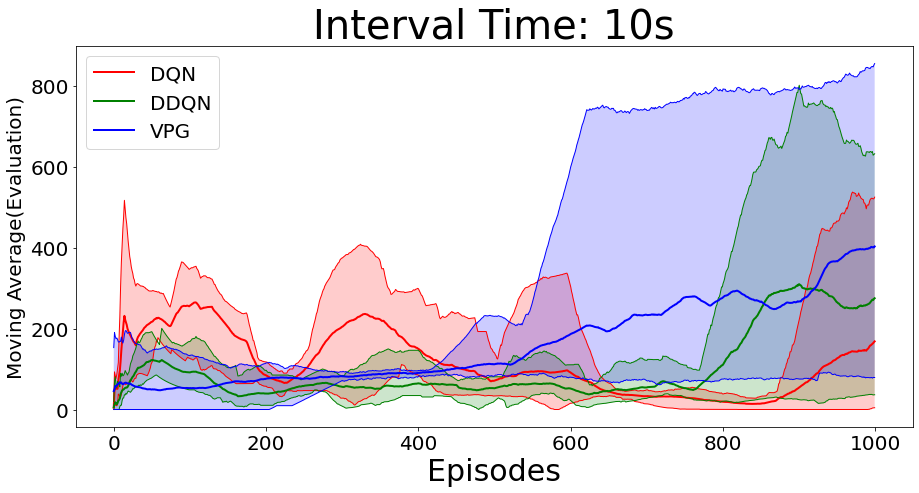

In [144]:
fig, axs = plt.subplots(1, 1, figsize=(15,7))

plt.plot(eval_dqn_max, 'r', linewidth=1)
plt.plot(eval_dqn_min, 'r', linewidth=1)
plt.plot(eval_dqn_mean, 'r', label='DQN', linewidth=2)
plt.fill_between(x, eval_dqn_min, eval_dqn_max, facecolor='r', alpha=0.2)

plt.plot(eval_ddqn_max, 'g', linewidth=1)
plt.plot(eval_ddqn_min, 'g', linewidth=1)
plt.plot(eval_ddqn_mean, 'g', label='DDQN', linewidth=2)
plt.fill_between(x, eval_ddqn_min, eval_ddqn_max, facecolor='g', alpha=0.2)

plt.plot(eval_vpg_max, 'b', linewidth=1)
plt.plot(eval_vpg_min, 'b', linewidth=1)
plt.plot(eval_vpg_mean, 'b', label='VPG', linewidth=2)
plt.fill_between(x, eval_vpg_min, eval_vpg_max, facecolor='b', alpha=0.2)


plt.legend(fontsize=20, loc='upper left')
plt.ylabel('Moving Average(Evaluation)', fontsize=20)
plt.xlabel('Episodes', fontsize=30)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Interval Time: 10s', fontsize=40)
plt.savefig('d_2.png')

In [135]:
train_ddqn_max_1, eval_ddqn_max_1 = np.max(ddqn_results_1, axis=0).T
train_ddqn_min_1, eval_ddqn_min_1 = np.min(ddqn_results_1, axis=0).T
train_ddqn_mean_1, eval_ddqn_mean_1 = np.mean(ddqn_results_1, axis=0).T
train_dqn_max_1, eval_dqn_max_1 = np.max(dqn_results_1, axis=0).T
train_dqn_min_1, eval_dqn_min_1 = np.min(dqn_results_1, axis=0).T
train_dqn_mean_1, eval_dqn_mean_1 = np.mean(dqn_results_1, axis=0).T
train_vpg_max_1, eval_vpg_max_1 = np.max(vpg_results_1, axis=0).T
train_vpg_min_1, eval_vpg_min_1 = np.min(vpg_results_1, axis=0).T
train_vpg_mean_1, eval_vpg_mean_1 = np.mean(vpg_results_1, axis=0).T
x = np.arange(np.max((len(train_ddqn_mean_1), len(train_dqn_mean_1))))

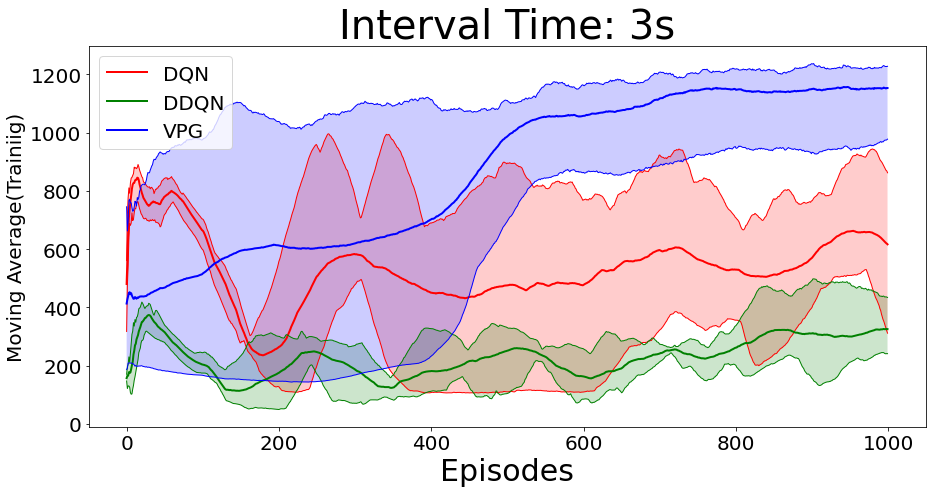

In [143]:
fig, axs = plt.subplots(1, 1, figsize=(15,7))

plt.plot(train_dqn_max_1, 'r', linewidth=1)
plt.plot(train_dqn_min_1, 'r', linewidth=1)
plt.plot(train_dqn_mean_1, 'r', label='DQN', linewidth=2)
plt.fill_between(x, train_dqn_min_1, train_dqn_max_1, facecolor='r', alpha=0.2)

plt.plot(train_ddqn_max_1, 'g', linewidth=1)
plt.plot(train_ddqn_min_1, 'g', linewidth=1)
plt.plot(train_ddqn_mean_1, 'g', label='DDQN', linewidth=2)
plt.fill_between(x, train_ddqn_min_1, train_ddqn_max_1, facecolor='g', alpha=0.2)

plt.plot(train_vpg_max_1, 'b', linewidth=1)
plt.plot(train_vpg_min_1, 'b', linewidth=1)
plt.plot(train_vpg_mean_1, 'b', label='VPG', linewidth=2)
plt.fill_between(x, train_vpg_min_1, train_vpg_max_1, facecolor='b', alpha=0.2)


plt.legend(fontsize=20, loc='upper left')
plt.ylabel('Moving Average(Trainiig)', fontsize=20)
plt.xlabel('Episodes', fontsize=30)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Interval Time: 3s', fontsize=40)
plt.savefig('d_3.png')

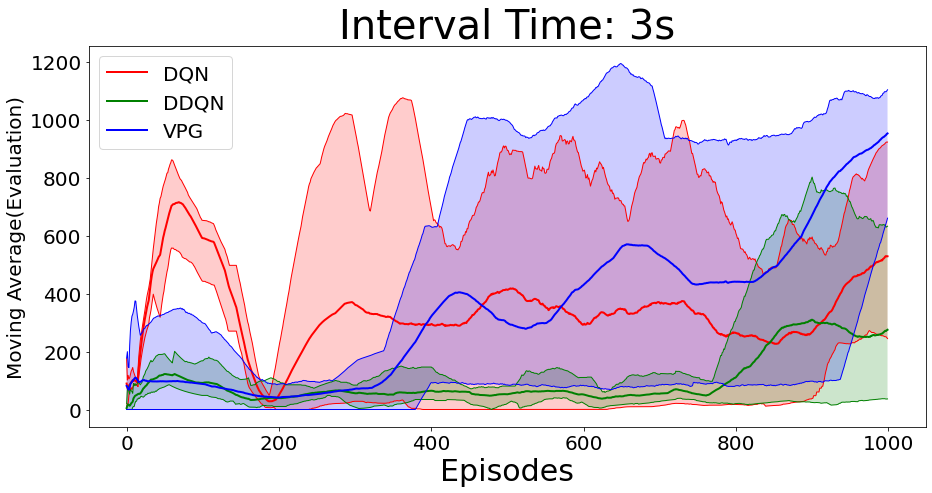

In [145]:
fig, axs = plt.subplots(1, 1, figsize=(15,7))

plt.plot(eval_dqn_max_1, 'r', linewidth=1)
plt.plot(eval_dqn_min_1, 'r', linewidth=1)
plt.plot(eval_dqn_mean_1, 'r', label='DQN', linewidth=2)
plt.fill_between(x, eval_dqn_min_1, eval_dqn_max_1, facecolor='r', alpha=0.2)

plt.plot(eval_ddqn_max_1, 'g', linewidth=1)
plt.plot(eval_ddqn_min_1, 'g', linewidth=1)
plt.plot(eval_ddqn_mean_1, 'g', label='DDQN', linewidth=2)
plt.fill_between(x, eval_ddqn_min_1, eval_ddqn_max_1, facecolor='g', alpha=0.2)

plt.plot(eval_vpg_max_1, 'b', linewidth=1)
plt.plot(eval_vpg_min_1, 'b', linewidth=1)
plt.plot(eval_vpg_mean_1, 'b', label='VPG', linewidth=2)
plt.fill_between(x, eval_vpg_min_1, eval_vpg_max_1, facecolor='b', alpha=0.2)


plt.legend(fontsize=20, loc='upper left')
plt.ylabel('Moving Average(Evaluation)', fontsize=20)
plt.xlabel('Episodes', fontsize=30)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Interval Time: 3s', fontsize=40)
plt.savefig('d_4.png')